# Sports Analysis
#### What statistics can predict a top finish/playoff entry?

Denis Bajic

Arjun Tanguturi

Sarthak Anand

In this project, we look at three different sporting leagues: National Hockey League (NHL), English Premier League (EPL), and National Basketball Association (NBA), with the hope to see which statistics best predict playoff entrance (NBA, NHL) or a top 10 finish (EPL).  
<br>
In the case of the NBA and the NHL, we take 9 seasons worth of team statistics scraped from the following websites:
* NBA: Real GM: http://basketball.realgm.com/
* NHL: Puckalytics: http://stats.hockeyanalysis.com/

<br>

For the English Premier League, we take 7 seasons worth of team statistics scraped from:
* EPL: WhoScored?: https://www.whoscored.com/

<br>

The idea is that given a combination of certain team statistics, we should be able to see which statistics are predictors of team success, either by influencing a team in making the playoffs, or obtaining a top-10 finish.

The following code is the processing for NHL statistics from the 2007-2008 to 2015-2016 seasons.

In [1]:
from bs4 import BeautifulSoup
import csv
import re
from urllib.request import Request, urlopen
import pandas as pd
import fileinput

def get_table_value(element):
    return " ".join(element.stripped_strings)

# NHL data in HTML tables; scrape and convert to CSV format
def scrape_data(url):
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'}) # So we don't get 403 Error'ed
    html = urlopen(req).read()

    soup = BeautifulSoup(html, "lxml") # Process the HTML
    f = open("testnhl.csv", 'a')
    output = csv.writer(f)

    # Write HTML rows to CSV
    for table in soup.find_all('table'):
        for row in table.find_all('tr'):
            col = map(get_table_value, row.find_all(re.compile('t[dh]')))
            output.writerow(col)
        output.writerow([]) 

    f.close()

# Remove blank/unnecessary rows
def remove_filler():
    with open('testnhl.csv', 'r') as inp, open('testnhl2.csv', 'w') as out:
        writer = csv.writer(out)
        for row in csv.reader(inp):
            if row and (not "most" in row[0]) and (not "Season:" in row[0]):
                writer.writerow(row)

In [2]:
urls = ["200708","200809","200910","201011","201112","201213","201314","201415","201516"]
# Scrape the data for each NHL season
for url in urls:
    scrape_data("http://stats.hockeyanalysis.com/teamstats.php?disp=1&db=" + url + "&sit=all&sort=team&sortdir=ASC")
remove_filler()

In [3]:
df = pd.read_csv("testnhl2.csv") # Load data into Pandas Dataframe

In [4]:
# Drop rows that repeat header
df.drop(df.index[[30,61,92,123,154,185,216,247]], inplace=True)

In [5]:
df.describe() # Initial table size and description of features

,#,Team,GP,TOI,GF,GA,GF60,GA60,GF%,SF,...,CA,CF60,CA60,CF%,Sh%,Sv%,PDO,OZFO%,DZFO%,NZFO%
count,270,270,270,270,270,270,270,270,270,270,...,270,270,270,270,270,270,270,270,270,270
unique,30,30,3,261,104,114,97,106,128,221,...,245,130,131,102,185,181,56,83,84,78
top,12,Edmonton,82,5009:58,213,216,2.56,2.59,53.1,2427,...,4763,56.6,51.5,52.0,8.81,91.41,100.3,32.8,33.2,32.0
freq,9,9,230,2,9,6,8,7,7,3,...,3,9,7,9,5,4,16,11,11,10


In [6]:
# Drop columns that don't contribute to anything

# Drop the ID for each team
df.drop(['#'], inplace=True, axis=1)

# Drop columns that are already described by other encompassing statistics

# GF, GA, and GF% are represented and normalized as GF60 and GA60
# SF, SA, SF60, SA60, and SF% are represented and normalized as CF%
df.drop(["GF", "GA", "GF%", "SF", "SA", "SF60", "SA60", "SF%"], inplace=True, axis=1)
# FF, FA, FF60, FA60, FF%, CF, CA, CF60, CA60 are represented/normalized as CF%
df.drop(["FF", "FA", "FF60", "FA60", "FF%", "CF", "CA", "CF60", "CA60"], inplace=True, axis=1)
# PDO is represented as Sh% and Sv%
df.drop(["PDO"], inplace=True, axis=1)

In [7]:
df.head() # What does the data look like right now?

,Team,GP,TOI,GF60,GA60,CF%,Sh%,Sv%,OZFO%,DZFO%,NZFO%
0,Anaheim,82,5002:05,2.35,2.21,50.7,8.76,91.98,31.2,29.5,39.2
1,Arizona,82,4934:33,2.50,2.70,49.0,8.41,91.08,30.6,31.7,37.7
2,Boston,82,4998:48,2.47,2.56,49.8,8.83,91.46,30.1,32.7,37.1
3,Buffalo,82,5009:58,3.01,2.79,50.2,10.14,89.97,31.6,29.6,38.8
4,Calgary,82,4973:02,2.73,2.70,52.0,9.76,90.39,31.2,30.1,38.7


There are 3 other features that we want to look at to get a better look at each team:
* PP%
* PK%
* Playoffs

This data was added in manually as it could not be scraped from a website.

In [8]:
df = pd.read_csv("data/NHLStatsFinal.csv") # Python-ready for analysis data

Rationale for feature selection:

* GF60: Goals Scored per 60 minutes - Measure of total offensive production. Higher number = better offense.
* GA60: Goals Allowed per 60 minutes - Measure of defensive presence. Lower number = better defense.
* CF% - Corsi For% - Measure of how much possession each team carried. Combines shots on goal + shots on target. Higher number = more possession
* Sh% - Shot% - Measure of how accurately each team shot
* Sv% - Save% - Measure of goaltender performance
* PP% - Power Play% - How effective is a team scoring when playing 5 vs. 4(3)
* PK% - Penalty Kill% - How well can a team avoid giving up goals playing 4(3) vs. 5
* O/D/NZFO% - Offensive/Defensive/Neutral Zone Faceoff% - Proportion of faceoffs taken in each zone of the ice
* Playoffs - Class Feature - Did that team make the playoffs?

In [9]:
df.head() # Data should be the same

,Unnamed: 0,Team,GP,TOI,GF60,GA60,CF%,Sh%,Sv%,OZFO%,DZFO%,NZFO%,PP%,PK%,Playoffs
0,0,Anaheim,82,5002:05:00,2.35,2.21,50.7,8.76,91.98,31.2,29.5,39.2,16.6,83.1,Yes
1,1,Arizona,82,4934:33:00,2.50,2.70,49.0,8.41,91.08,30.6,31.7,37.7,18.6,80.7,No
2,2,Boston,82,4998:48:00,2.47,2.56,49.8,8.83,91.46,30.1,32.7,37.1,17.2,78.6,Yes
3,3,Buffalo,82,5009:58:00,3.01,2.79,50.2,10.14,89.97,31.6,29.6,38.8,18.0,83.2,No
4,4,Calgary,82,4973:02:00,2.73,2.70,52.0,9.76,90.39,31.2,30.1,38.7,16.8,81.5,Yes


In [10]:
# Still have to do a little bit of cleanup...
df.drop(['Unnamed: 0', 'GP', 'TOI'], inplace=True, axis=1)
pd.DataFrame.to_csv(df, "NHLStats.csv", index=False)
df.drop(['Team'], inplace=True, axis=1)

In [11]:
df.head() # Only numeric statistics are left over

,GF60,GA60,CF%,Sh%,Sv%,OZFO%,DZFO%,NZFO%,PP%,PK%,Playoffs
0,2.35,2.21,50.7,8.76,91.98,31.2,29.5,39.2,16.6,83.1,Yes
1,2.50,2.70,49.0,8.41,91.08,30.6,31.7,37.7,18.6,80.7,No
2,2.47,2.56,49.8,8.83,91.46,30.1,32.7,37.1,17.2,78.6,Yes
3,3.01,2.79,50.2,10.14,89.97,31.6,29.6,38.8,18.0,83.2,No
4,2.73,2.70,52.0,9.76,90.39,31.2,30.1,38.7,16.8,81.5,Yes


In [12]:
Y = df.pop("Playoffs") # Pop the classes from the dataframe

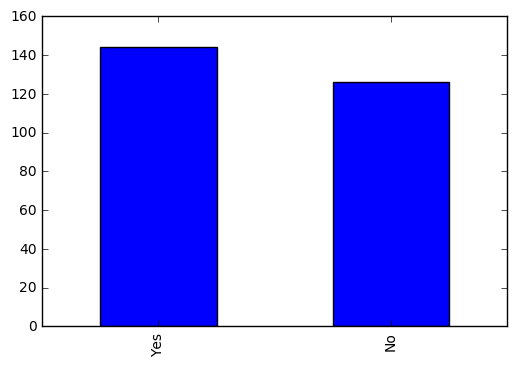

In [13]:
# Bar plot of frequencies of target playoff variable
import matplotlib.pyplot as plt
% matplotlib inline
Y.value_counts().plot(kind='bar')

In [14]:
# Print data shape and statistics for the other features
print("Shape: ", df.shape)
df.describe() # Statistics for numerical features

Shape:  (270, 10)


,GF60,GA60,CF%,Sh%,Sv%,OZFO%,DZFO%,NZFO%,PP%,PK%
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,2.660333,2.660148,50.000741,9.068222,90.934630,33.146667,33.117778,33.740370,18.056667,81.752963
std,0.278528,0.302602,2.811276,0.841041,0.875281,1.953200,2.159783,2.115521,2.719271,2.981138
min,1.790000,1.860000,38.000000,6.900000,88.460000,26.700000,25.000000,30.200000,10.000000,71.900000
25%,2.472500,2.442500,48.100000,8.552500,90.267500,32.000000,32.000000,32.200000,16.100000,80.100000
50%,2.645000,2.640000,50.200000,9.050000,91.015000,33.150000,33.100000,33.200000,17.950000,81.750000
75%,2.840000,2.860000,52.000000,9.597500,91.517500,34.400000,34.375000,34.500000,19.400000,83.700000
max,3.740000,3.500000,59.100000,11.600000,93.340000,38.400000,40.300000,40.700000,26.800000,89.600000


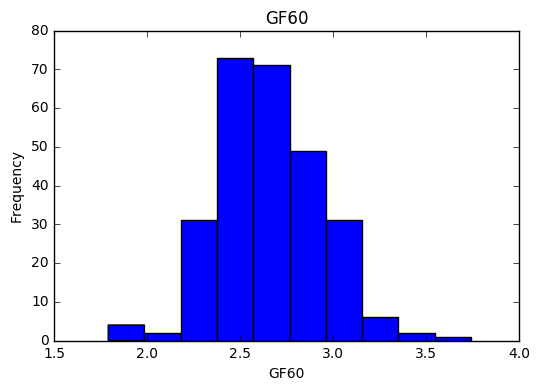

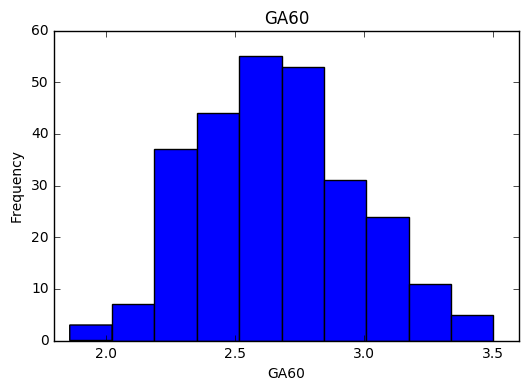

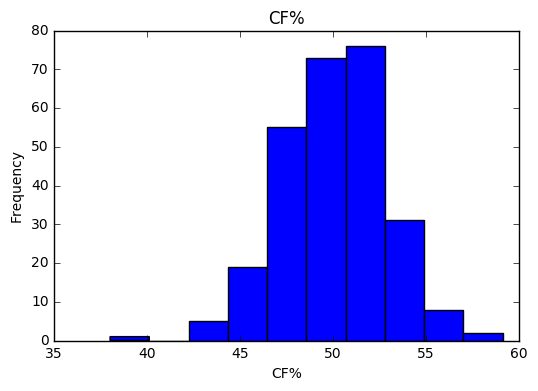

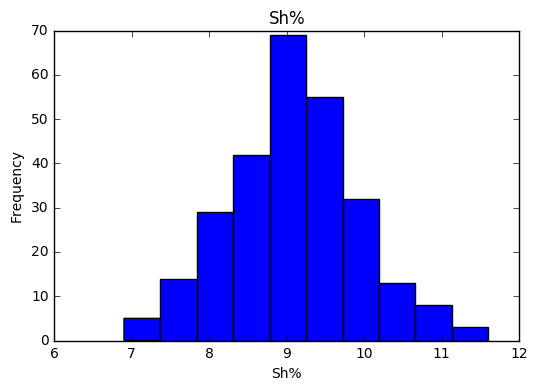

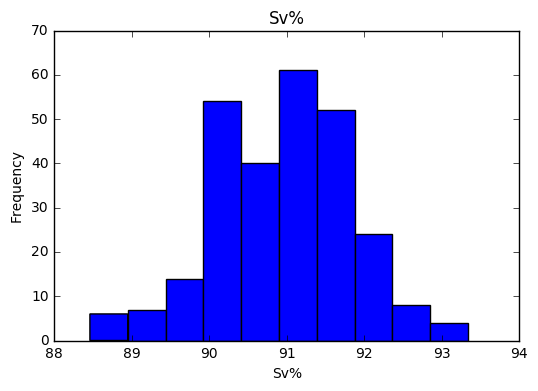

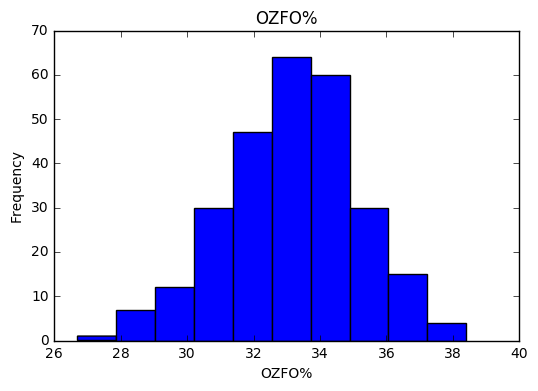

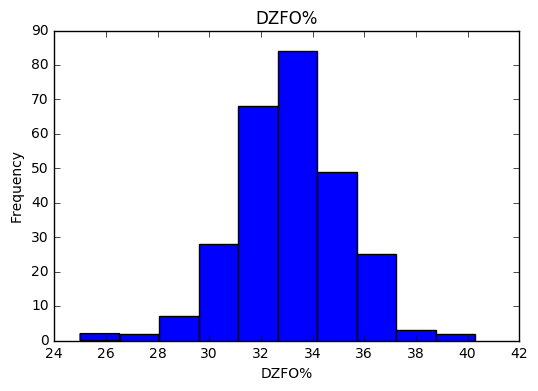

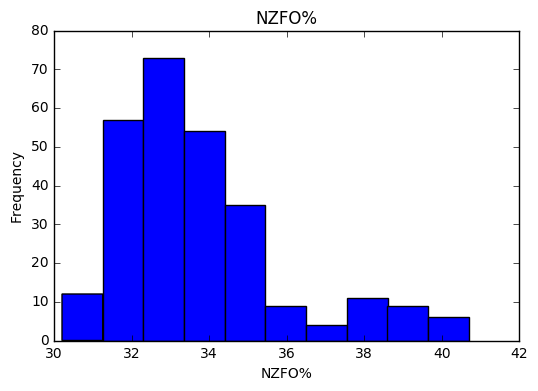

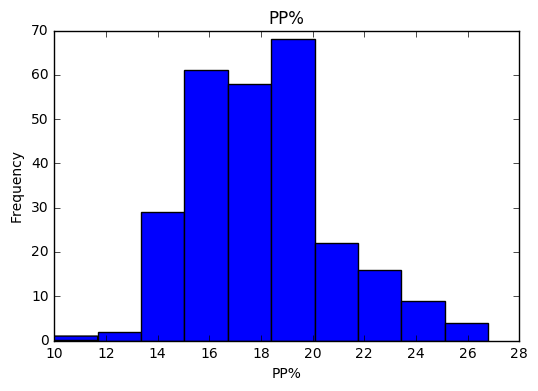

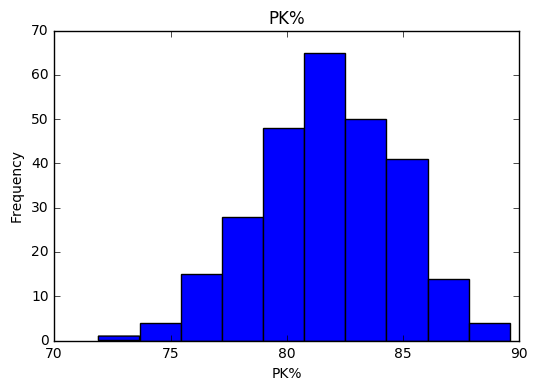

In [15]:
# Histograms for numerical features [ADD LABELS]
% matplotlib inline
plt.figure(1)
df['GF60'].plot(kind='hist', title='GF60')
plt.xlabel('GF60')
plt.figure(2)
df['GA60'].plot(kind='hist', title='GA60')
plt.xlabel('GA60')
plt.figure(3)
df['CF%'].plot(kind='hist', title='CF%')
plt.xlabel('CF%')
plt.figure(4)
df['Sh%'].plot(kind='hist', title='Sh%')
plt.xlabel('Sh%')
plt.figure(5)
df['Sv%'].plot(kind='hist', title='Sv%')
plt.xlabel('Sv%')
plt.figure(6)
df['OZFO%'].plot(kind='hist', title='OZFO%')
plt.xlabel('OZFO%')
plt.figure(7)
df['DZFO%'].plot(kind='hist', title='DZFO%')
plt.xlabel('DZFO%')
plt.figure(8)
df['NZFO%'].plot(kind='hist', title='NZFO%')
plt.xlabel('NZFO%')
plt.figure(9)
df['PP%'].plot(kind='hist', title='PP%')
plt.xlabel('PP%')
plt.figure(10)
df['PK%'].plot(kind='hist', title='PK%')
plt.xlabel('PK%')

The following code is for the processing of EPL statistics from 2009-2010 to 2015-2016 seasons.

In [16]:
# Read scraped data from CSV to Pandas Dataframes
df1516 = pd.read_csv("data/PL201516.csv")
df1415 = pd.read_csv("data/PL201415.csv")
df1314 = pd.read_csv("data/PL201314.csv")
df1213 = pd.read_csv("data/PL201213.csv")
df1112 = pd.read_csv("data/PL201112.csv")
df1011 = pd.read_csv("data/PL201011.csv")
df0910 = pd.read_csv("data/PL200910.csv")

In [17]:
# Create class labels
label = ['Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','Yes','No','No','No','No','No','No','No','No','No','No']
Y = pd.DataFrame({'Top10': label})

In [18]:
# Append labels to dataframes
df1516 = pd.concat([df1516,Y], axis=1, join_axes=[df1516.index])
df1415 = pd.concat([df1415,Y], axis=1, join_axes=[df1415.index])
df1314 = pd.concat([df1314,Y], axis=1, join_axes=[df1314.index])
df1213 = pd.concat([df1213,Y], axis=1, join_axes=[df1213.index])
df1112 = pd.concat([df1112,Y], axis=1, join_axes=[df1112.index])
df1011 = pd.concat([df1011,Y], axis=1, join_axes=[df1011.index])
df0910 = pd.concat([df0910,Y], axis=1, join_axes=[df0910.index])

In [19]:
df1516.head() # What does the data look like?

,No.,Team,Shots Per Game,Yellow Cards,Red Cards,Possession%,PassSuccess%,AerialsWon,Rating,Top10
0,1,Arsenal,15.1,40,4,56.9,84.2,15.2,7.08,Yes
1,2,Leicester,13.7,48,3,44.8,70.5,18.8,7.06,Yes
2,3,Tottenham,17.3,72,0,55.3,80.5,14.3,7.01,Yes
3,4,Manchester City,16.2,61,0,55.2,83.1,15.7,7.01,Yes
4,5,West Ham,14.7,58,5,49.1,77.6,17.7,6.92,Yes


Rationale for feature selection:

* Shots Per Game: How many shots directed on target per game
* Yellow Cards: How many cautions awarded to the team per season
* Red Cards: How many ejections awared to the team per season
* Possession%: How much possession each team carried on average
* PassSuccess%: How successful each team was passing the ball
* AerialsWon: How many aerial balls won for each team
* PK% - Penalty Kill% - How well can a team avoid giving up goals playing 4(3) vs. 5
* O/D/NZFO% - Offensive/Defensive/Neutral Zone Faceoff% - Proportion of faceoffs taken in each zone of the ice
* Top10: Did the team finish in the top 10?

In [20]:
# Merge dataframes into one dataframe
df = df1516.append([df1415, df1314, df1213, df1112, df1011, df0910])
pd.DataFrame.to_csv(df, "EPLStats.csv", index=False)

In [21]:
# Drop unnecessary features
df.drop(['No.','Team ','Rating'], inplace=True, axis=1)

In [22]:
# Print data shape and statistics for numerical features
print(df.shape)
df.describe()

(140, 7)


,Shots Per Game,Yellow Cards,Red Cards,Possession%,PassSuccess%,AerialsWon
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000
mean,13.768571,60.878571,3.100000,50.002857,77.005000,15.917857
std,2.443788,9.407993,1.828236,4.346866,5.638847,3.783936
min,9.900000,40.000000,0.000000,41.000000,62.200000,5.900000
25%,11.850000,54.750000,2.000000,46.475000,73.600000,13.650000
50%,13.400000,60.000000,3.000000,49.500000,77.100000,15.700000
75%,15.225000,66.250000,4.000000,54.250000,81.650000,18.200000
max,21.900000,94.000000,9.000000,58.800000,85.500000,28.900000


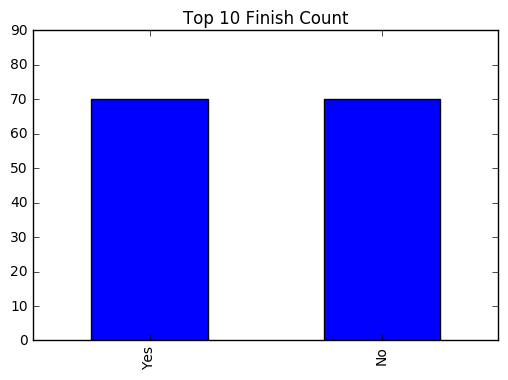

In [23]:
# Visualize target variable
Top10 = df.pop("Top10")
Top10.value_counts().plot(kind='bar', ylim=(0,90), title='Top 10 Finish Count')

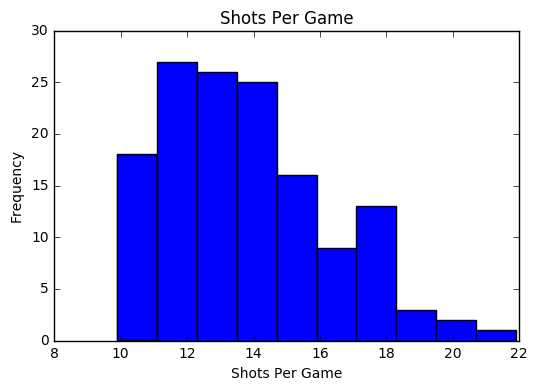

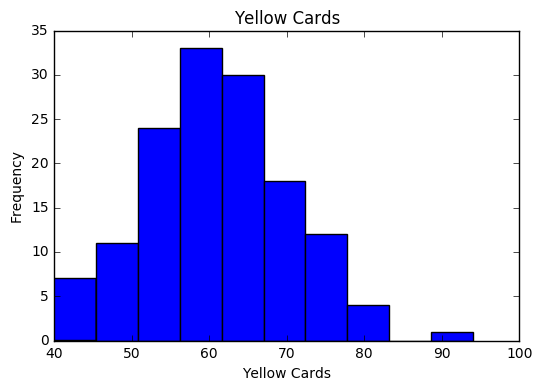

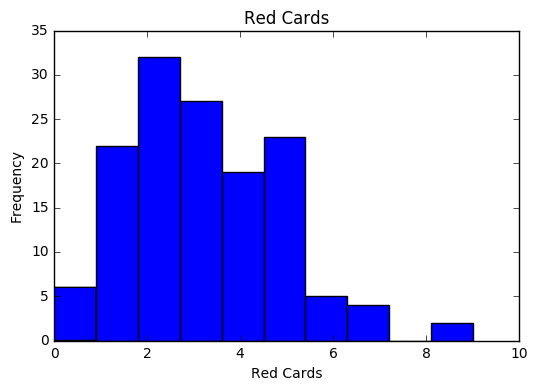

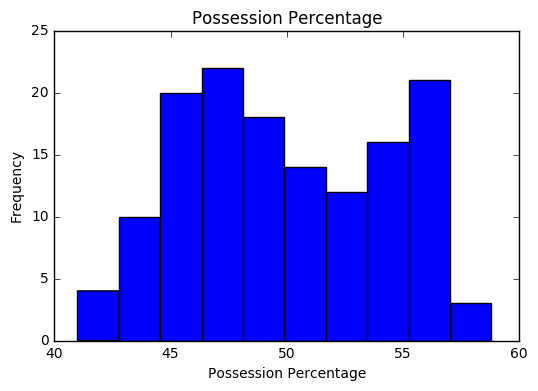

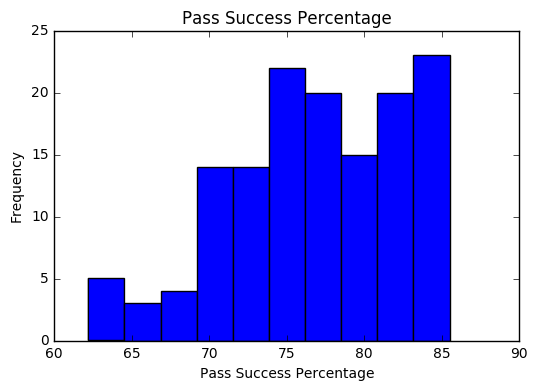

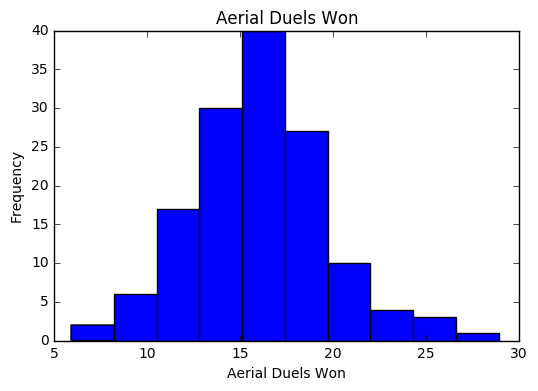

In [24]:
# Histogram for numerical features
plt.figure(1)
df['Shots Per Game '].plot(kind='hist', title='Shots Per Game')
plt.xlabel('Shots Per Game')
plt.figure(2)
df['Yellow Cards'].plot(kind='hist', title='Yellow Cards')
plt.xlabel('Yellow Cards')
plt.figure(3)
df['Red Cards'].plot(kind='hist', title='Red Cards')
plt.xlabel('Red Cards')
plt.figure(4)
df['Possession%'].plot(kind='hist', title='Possession Percentage')
plt.xlabel('Possession Percentage')
plt.figure(5)
df['PassSuccess%'].plot(kind='hist', title='Pass Success Percentage')
plt.xlabel('Pass Success Percentage')
plt.figure(6)
df['AerialsWon'].plot(kind='hist', title='Aerial Duels Won')
plt.xlabel('Aerial Duels Won')

The following code is the processing for NBA statistics from the 2007-2008 to 2015-2016 seasons.

In [25]:
playoff_dictionary= {}
f = open("NBAPlayoffs.txt")
for line in f:
    data = line.split(":")
    playoff_dictionary[int(data[0])] = data[1].strip().split(",")
#Find which teams are in playoffs based on year.
#Data file was manually made using data from NBA.com
print(playoff_dictionary[2008])

['Boston', 'Detroit', 'Orlando', 'Cleveland', 'Washington', 'Toronto', 'Philadelphia', 'Atlanta', 'L.A. Lakers', 'New Orleans', 'San Antonio', 'Utah', 'Houston', 'Phoenix', 'Dallas', 'Denver']


In [26]:
# NBA data in HTML tables; scrape and convert to CSV format
# year is used to find if team made playoffs or not.
def scrape_data_nba(url,year):
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'}) # So we don't get 403 Error'ed
    html = urlopen(req).read()
    soup = BeautifulSoup(html, "lxml")
    f = open("NBAData.csv", 'a', newline='')
    output = csv.writer(f,delimiter=',')
    for table in soup.find('table'):
        for row in table.find_all('tr'):
            col = [x.getText() for x in row.find_all(re.compile('t[dh]'))]
            if col[0] == "#":
                col.append("Playoffs")
            elif col[1] in playoff_dictionary[year]:
                col.append("Yes")
            else:
                col.append("No")
            output.writerow(col)
    f.close()

In [27]:
for i in range(2008,2017):#from 2007-08 season, upto 2016-2017 season exclusive(current season)
    scrape_data_nba("http://basketball.realgm.com/nba/team_stats/"+str(i)+"/Averages/Team_Totals/Regular_Season/",i)

In [28]:
df = pd.read_csv("NBAData.csv")

In [29]:
# Drop rows that repeat header
df.drop(df.index[[30,61,92,123,154,185,216,247]], inplace=True)

In [30]:
df.describe()

,#,Team,GP,MPG,FGM,FGA,FG%,3PM,3PA,3P%,...,TOV,PF,ORB,DRB,RPG,APG,SPG,BPG,PPG,Playoffs
count,270,270,270,270,270,270,270,270,270,270,...,270,270,270,270,270,270,270,270,270,270
unique,30,32,3,11,66,98,69,71,132,79,...,49,63,56,68,75,73,43,35,134,2
top,12,Utah,82,48.4,38.1,81.7,.458,6.7,18.0,.346,...,14.0,20.0,11.1,31.9,41.7,21.0,7.0,4.8,97.3,Yes
freq,9,9,238,67,12,8,12,11,7,10,...,17,14,12,11,11,11,14,17,5,144


In [31]:
pd.DataFrame.to_csv(df, "NBAStats.csv", index=False)
# Drop columns that don't contribute to anything
df.drop(['#'], inplace=True, axis=1)
# Drop columns that are already described by other encompassing statistics
df.drop(["GP", "MPG","FGA","3PA", "FTA","Team"], inplace=True, axis=1)
# GP, and MPG are uniform (or very very close to uniform), FGA,3PA, and FTA can be derived from other features. (Attempted/Made = %)

In [32]:
df.head()

,FGM,FG%,3PM,3P%,FTM,FT%,TOV,PF,ORB,DRB,RPG,APG,SPG,BPG,PPG,Playoffs
0,41.5,.459,9.3,.348,18.8,.752,13.2,22.9,12.7,30.4,43.2,22.4,9.1,4.6,111.0,No
1,40.3,.470,6.9,.355,23.1,.751,14.7,21.1,11.2,32.9,44.1,24.7,9.2,6.7,110.7,Yes
2,41.4,.500,8.5,.393,18.9,.783,14.4,19.9,8.8,32.7,41.5,26.7,6.5,6.3,110.1,Yes
3,39.6,.476,8.1,.378,21.3,.769,14.1,20.6,11.0,33.2,44.1,24.4,8.0,5.3,108.6,Yes
4,40.0,.497,5.0,.372,21.3,.759,14.6,24.0,11.5,29.4,40.9,26.4,8.7,4.3,106.2,Yes


Rationale for Feature Selection:
- Offensive Contributions
    - FGM - Field Goals Made per Game: # of 2 and 3 pointers made by team in a game.
    - FG% - Percentage of Field Goals made: Percentage of 2 and 3 pointers made
    - 3PM - # of 3 pointers made per game
    - 3P% - Percentage of 3 pointers made per game
    - FTM - Free throws made per game
    - FT% - Free throw percentage per game
    - ORB - Offensive Rebounds per Game
    - RB  - # of Rebounds per Game
    - PPG - Points per game. Higher number means better offense.
    - APG - Assists per Game
- Defensive Contributions
    - TOV - Turnovers: Loss of possession of ball. Higher number = worse defense
    - PF  - Personal Fouls: Fouls made
    - DRB - Defensive Rebounds per Game
    - SPG - Steals per Game
    - BPG - Blocks per Game
    
Playoffs - Target Variable- Either yes or no based on whether team made playoffs.

The percentages give us normalized values (for 3P,FT,and FG). However, it's important to have the actual value as well, since a high percentage doesn't neccessarily translate to relatively high 3P,FT or FG.

In [33]:
Y = df.pop("Playoffs") # Just Target variable column
df = df.apply(pd.to_numeric) # Left with numeric data after popping Playoffs Column

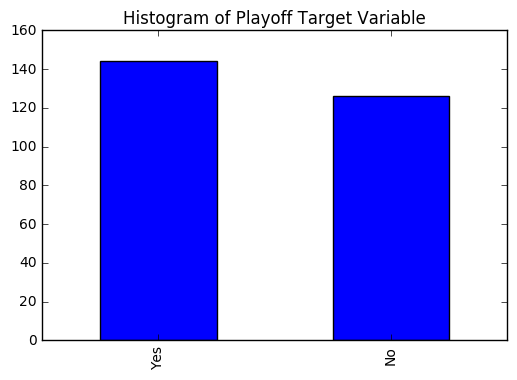

In [34]:
Y.value_counts().plot(kind='bar',title="Histogram of Playoff Target Variable")

In [35]:
print(df.shape) # Data shape
df.describe() # Statistics for the other features

(270, 15)


,FGM,FG%,3PM,3P%,FTM,FT%,TOV,PF,ORB,DRB,RPG,APG,SPG,BPG,PPG
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,37.375185,0.454781,7.087778,0.355570,17.933333,0.757907,14.351481,20.470741,10.984444,31.294815,42.276296,21.655556,7.536296,4.884815,99.772963
std,1.550565,0.015723,1.650357,0.019706,1.957884,0.029324,1.076851,1.421501,1.197759,1.707509,1.874847,1.755741,0.899410,0.757730,4.484816
min,33.200000,0.408000,3.700000,0.295000,12.200000,0.660000,11.200000,16.800000,7.600000,27.200000,36.900000,17.400000,5.500000,2.500000,87.000000
25%,36.400000,0.444000,6.000000,0.343000,16.500000,0.741250,13.700000,19.500000,10.300000,30.000000,41.000000,20.400000,7.000000,4.325000,96.700000
50%,37.300000,0.454000,6.900000,0.355000,17.700000,0.759000,14.450000,20.400000,11.000000,31.200000,42.100000,21.450000,7.500000,4.800000,99.200000
75%,38.300000,0.464000,8.100000,0.369000,19.100000,0.777000,15.000000,21.400000,11.800000,32.500000,43.500000,22.700000,8.175000,5.400000,102.700000
max,42.500000,0.504000,13.100000,0.416000,24.100000,0.828000,17.700000,24.200000,14.600000,36.200000,48.600000,28.900000,10.000000,8.200000,114.900000


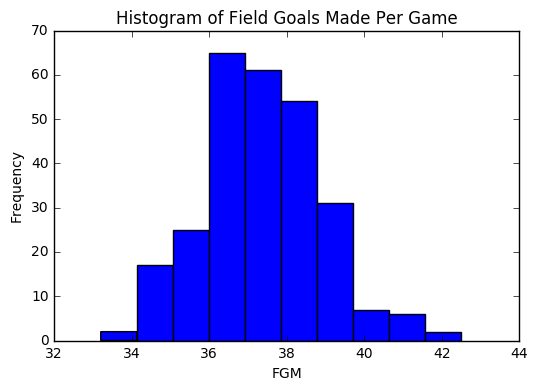

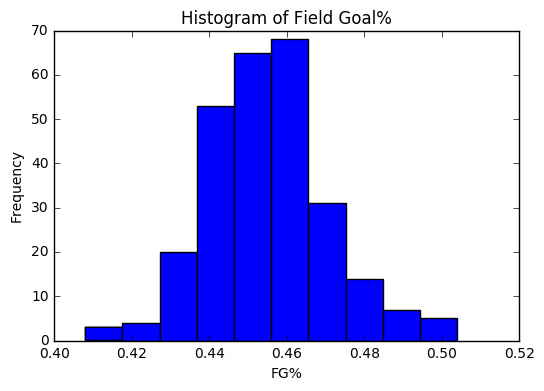

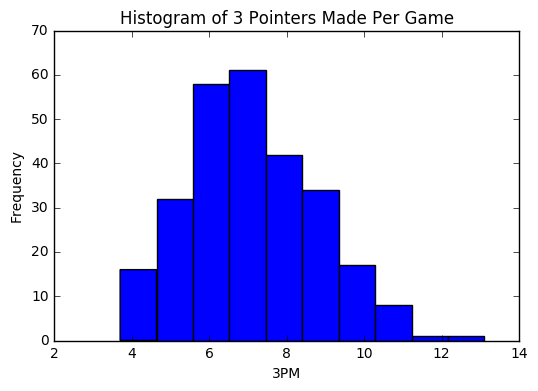

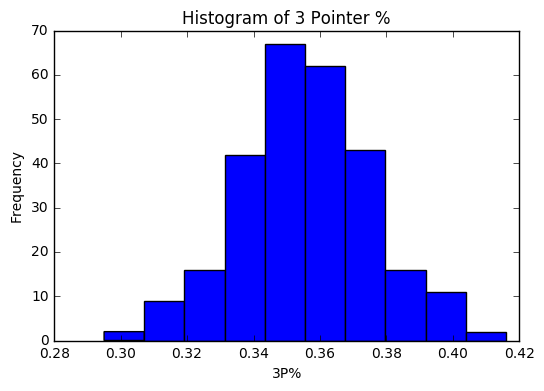

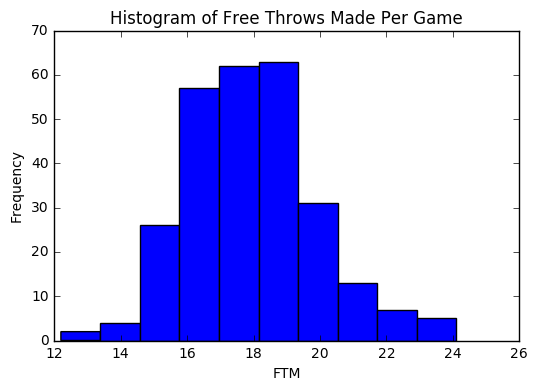

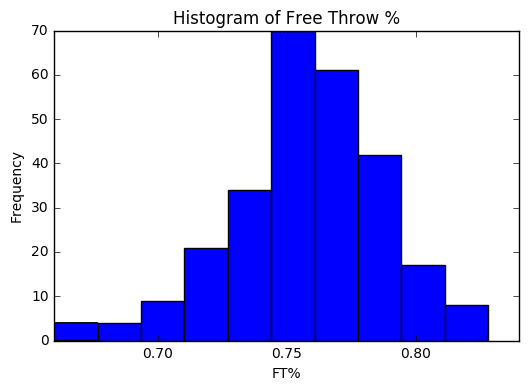

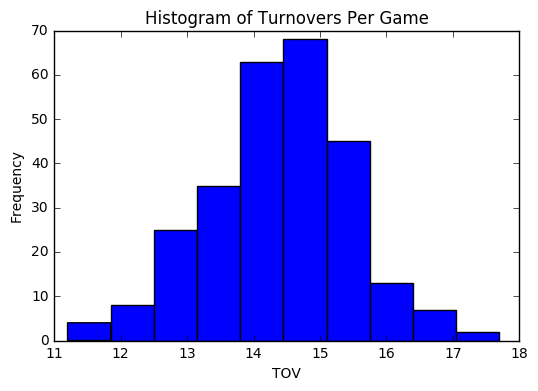

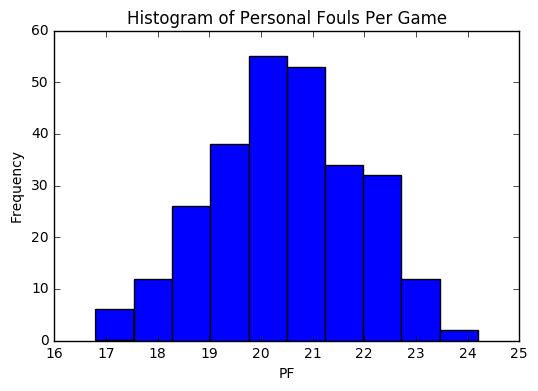

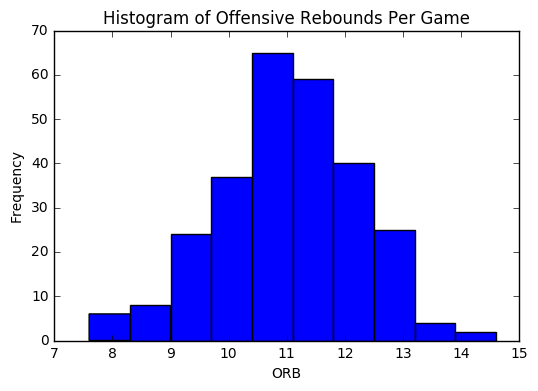

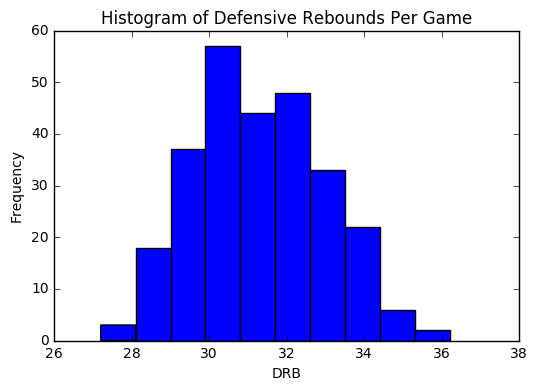

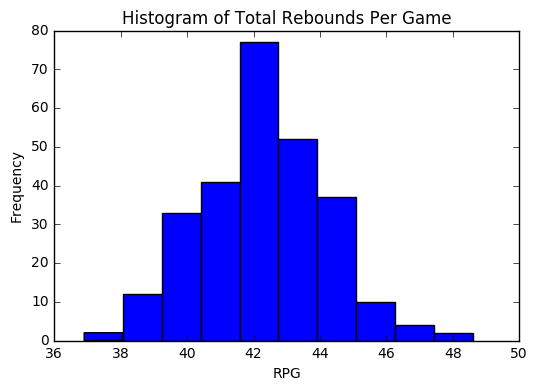

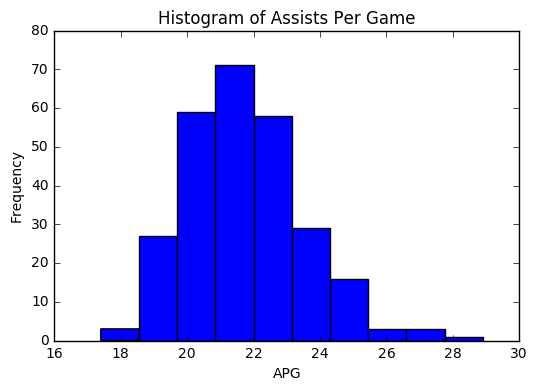

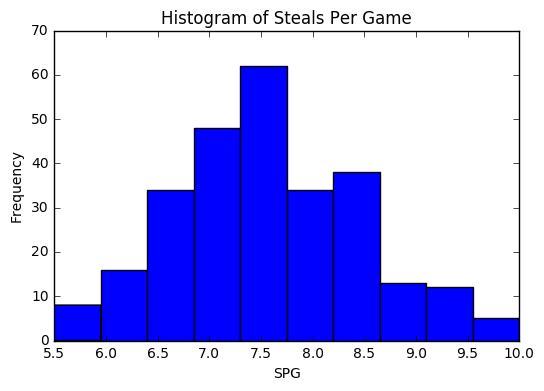

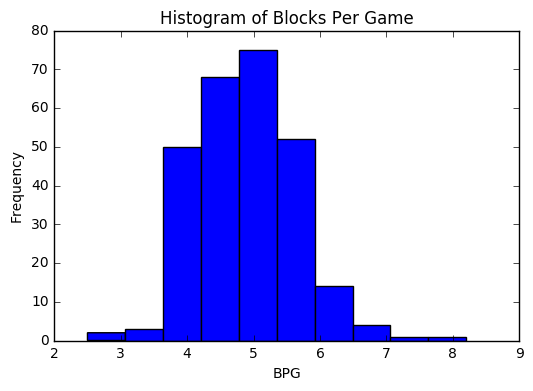

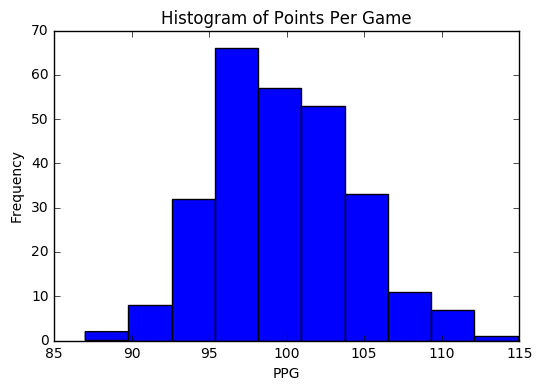

In [36]:
# Histograms for numerical features
% matplotlib inline
plt.figure(1)
df['FGM'].plot(kind='hist', title ="Histogram of Field Goals Made Per Game")
plt.xlabel("FGM")
plt.figure(2)
df['FG%'].plot(kind='hist', title= "Histogram of Field Goal%")
plt.xlabel("FG%")
plt.figure(3)
df['3PM'].plot(kind='hist', title="Histogram of 3 Pointers Made Per Game")
plt.xlabel("3PM")
plt.figure(4)
df['3P%'].plot(kind='hist', title="Histogram of 3 Pointer %")
plt.xlabel("3P%")
plt.figure(5)
df['FTM'].plot(kind='hist', title="Histogram of Free Throws Made Per Game")
plt.xlabel("FTM")
plt.figure(6)
df['FT%'].plot(kind='hist', title="Histogram of Free Throw %")
plt.xlabel("FT%")
plt.figure(7)
df['TOV'].plot(kind='hist', title="Histogram of Turnovers Per Game")
plt.xlabel("TOV")
plt.figure(8)
df['PF'].plot(kind='hist',title="Histogram of Personal Fouls Per Game")
plt.xlabel("PF")
plt.figure(9)
df['ORB'].plot(kind='hist',title="Histogram of Offensive Rebounds Per Game")
plt.xlabel("ORB")
plt.figure(10)
df['DRB'].plot(kind='hist',title="Histogram of Defensive Rebounds Per Game")
plt.xlabel("DRB")
plt.figure(11)
df['RPG'].plot(kind='hist', title="Histogram of Total Rebounds Per Game")
plt.xlabel("RPG")
plt.figure(12)
df['APG'].plot(kind='hist', title="Histogram of Assists Per Game")
plt.xlabel("APG")
plt.figure(13)
df['SPG'].plot(kind='hist', title="Histogram of Steals Per Game")
plt.xlabel("SPG")
plt.figure(14)
df['BPG'].plot(kind='hist', title="Histogram of Blocks Per Game")
plt.xlabel("BPG")
plt.figure(15)
df['PPG'].plot(kind='hist', title="Histogram of Points Per Game")
plt.xlabel("PPG")